In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv3D, Conv2D, Conv1D, Dropout, MaxPooling2D, LeakyReLU, BatchNormalization, Reshape, InputLayer, Input, ZeroPadding3D, ZeroPadding2D, UpSampling2D, UpSampling3D, MaxPool3D, MaxPooling3D, LSTM
from tensorflow.keras.layers import MaxPooling3D, TimeDistributed, Embedding
from tensorflow.keras.layers import Concatenate, Conv2DTranspose
from tensorflow.keras.models import Sequential, load_model, Model, save_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [18]:
def build_discriminator(load_mode=False):
    
    if load_model == True:
        model_dir = 'C:/Users/Steph/#Binus/#Bangkit/#Project/Dataset/bisindo/saved_model/disc_cond'
        model = tf.saved_model.load(
            model_dir
        )
        return model
    
    
    img_shape = (125, 125, 1)
    n_classes = 26    # 26 alphabet
    
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    li = Dense(np.prod(img_shape))(li)
    li = Reshape(img_shape)(li)
    
    
    in_image = Input(shape=img_shape)
    
    merge = Concatenate()([in_image, li])
    fe = Conv2D(128, kernel_size=5, strides=2, padding="same")(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    fe = Conv2D(256, kernel_size=3, strides=2, padding="same")(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    fe = Flatten()(fe)
    fe = Dense(64, activation='relu')(fe)
    fe = Dense(86, activation='relu')(fe)
    fe = Dense(128, activation='relu')(fe)
    out_layer = Dense(1, activation='sigmoid')(fe)
    
    discriminator = Model([in_image, in_label], out_layer, name='Discriminator_Conditional')
    opt = Adam(lr=0.0002, beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return discriminator

In [17]:
def build_generator(load_model=False):
    
    if load_model == True:
        model_dir = 'C:/Users/Steph/#Binus/#Bangkit/#Project/Dataset/bisindo/saved_model/generator_cond_11052021152246/'
        model = tf.saved_model.load(
            model_dir
        )
        return model
    
    noise_dim = 100
    n_classes = 26    # 26 alphabet
    
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    li = Dense(7*7*1, activation='relu', name='Dense_1')(li)
    li = Reshape((7, 7, 1))(li)
    in_lat = Input(shape=(noise_dim,))
    gen = Dense(128 * 7 * 7, activation='relu')(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    merge = Concatenate()([gen, li])
    gen = Conv2DTranspose(128, (5,5), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = BatchNormalization(momentum=0.8)(gen)
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
#     gen = BatchNormalization(momentum=0.8)
    gen = Flatten()(gen)
    gen = Dropout(0.4)(gen)
    gen = Dense(256, activation='relu', name='Dense_2')(gen)
    gen = Dense(128, activation='relu', name='Dense_3')(gen)
    gen = Dense(128, activation='relu', name='Dense_4')(gen)
    gen = Dense(256, activation='relu', name='Dense_5')(gen)
    gen = Dense(300, activation='relu', name='Dense_6')(gen)
    gen = Dense(400, activation='relu', name='Dense_7')(gen)
    gen = Dense(np.prod((125, 125)), activation='tanh', name='Dense_Output')(gen)
    gen = Reshape((125, 125, 1))(gen)
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    
    model = Model([in_lat, in_label], out_layer)
    return model
    

In [8]:
# define the combined generator and discriminator model, for updating the generator
def build_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [9]:
# load fashion mnist images
def load_real_samples():
    data = np.load('data_resized.npy')  # video
    videoFrameCount = np.load('data_videoFrameCount.npy')
    
    images = np.array([])
    count = 0

    for image in data:
        count += 1
        if count == 1:
            images = [image[int(videoFrameCount[3]/2)]]
        else:
            images = np.append(images, [image[int(videoFrameCount[3]/2)]], axis=0)
    
    
    labels = np.array([])
    count = 0

    for dir in os.listdir('./bisindo - video dataset/Train'):
        for video in os.listdir('./bisindo - video dataset/Train/' + dir):
            count += 1
            if count == 1:
                labels = [[dir]]
            else:
                labels = np.append(labels, [[dir]], axis=0)
                
    images = images.astype('float32')
    images = (images - 0.5) / 0.5
    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(labels)
    
    return [images, labels]

In [10]:
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = np.random.randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    return [X, labels], y

In [11]:
def generate_noise(noise_dim, n_samples, n_classes=26):
    x_input = np.random.randn(noise_dim * n_samples)
    z_input = x_input.reshape(n_samples, noise_dim)
    # generate labels
    labels = np.random.randint(0, n_classes, n_samples)
    return [z_input, labels]

In [12]:
def generate_fake_samples(generator, noise_dim, n_samples):
    z_input, labels_input = generate_noise(noise_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y

In [122]:
def train(g_model, d_model, gan_model, dataset, noise_dim, n_epochs=100, n_batch=13):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
#             print('1')
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
#             print('2')
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
#             print('3')
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, noise_dim, half_batch)
#             print('4')
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
#             print('5')
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_noise(noise_dim, n_batch)
#             print('6')
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
#             print('7')
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
#             print('8')
            # summarize loss on this batch
        if i%(n_epochs//10) == 0:
            print('>%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, d_loss1, d_loss2, g_loss))
                
    # save the generator model
#     g_model.save('cgan_generator.h5')

In [26]:
# create the discriminator
d_model = build_discriminator()
# create the generator
g_model = build_generator()
# create the gan
gan_model = build_gan(g_model, d_model)
# load image data
dataset = load_real_samples()

C:\Users\Steph\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
gan_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 6272)         633472      input_10[0][0]                   
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        1300        input_9[0][0]                    
____________________________________________________________________________________________

In [150]:
noise_dim = 100
train(g_model, d_model, gan_model, dataset, noise_dim, n_epochs=1000)

>1, d1=0.132, d2=0.200 g=5.743
>101, d1=0.000, d2=0.123 g=6.665
>201, d1=0.444, d2=0.296 g=3.039
>301, d1=0.177, d2=0.316 g=2.613
>401, d1=0.607, d2=0.067 g=2.865
>501, d1=0.489, d2=0.274 g=3.580
>601, d1=0.660, d2=0.137 g=4.801
>701, d1=0.206, d2=0.035 g=3.705
>801, d1=0.103, d2=0.281 g=5.967
>901, d1=0.008, d2=0.008 g=6.491


In [47]:
# save the model
g_model.save('./saved_model/cgan_generator.h5')
d_model.save('./saved_model/cgan_discriminator.h5')
gan_model.save('./saved_model/cgan_gan.h5')

In [2]:
g_model = load_model('./saved_model/cgan_generator.h5')
d_model = load_model('./saved_model/cgan_discriminator.h5')

In [115]:
gan_model1 = build_gan(g_model1, d_model1)

In [125]:
noise_dim = 100
train(g_model1, d_model1, gan_model1, dataset, noise_dim, n_epochs=1000)

>1, d1=0.375, d2=5.285 g=0.551
>101, d1=0.450, d2=7.942 g=0.447
>201, d1=0.266, d2=6.093 g=0.054
>301, d1=0.150, d2=7.112 g=0.185
>401, d1=0.045, d2=11.396 g=0.001
>501, d1=0.159, d2=9.026 g=0.002
>601, d1=0.317, d2=11.922 g=0.003
>701, d1=0.000, d2=10.743 g=0.000
>801, d1=0.178, d2=10.385 g=0.000
>901, d1=0.425, d2=11.569 g=0.000


In [29]:
from datetime import datetime
now = datetime.now()

g_model.save('saved_model/generator_cond_' + now.strftime("%d%m%Y%H%M%S"))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/generator_cond_11052021152246\assets


In [3]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=26):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

In [30]:
latent_points, labels = generate_latent_points(100, 2)

In [32]:
labels

array([13, 19])

In [33]:
latent_points.shape

(2, 100)

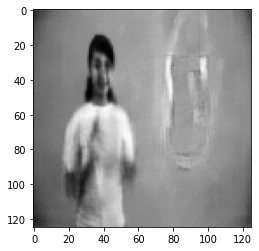

In [34]:
gen_img = g_model.predict([latent_points, labels])
plt.imshow(gen_img[0], cmap='gray')

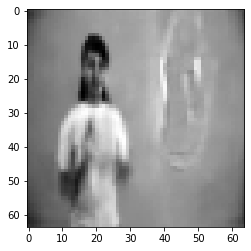

In [36]:
size = 200 # percent of original size
width = int(64)
height = int(64)
dim = (width, height)
  
# resize image
resized = cv2.resize(gen_img[0], dim, interpolation = cv2.INTER_AREA)
resized2 = cv2.resize(gen_img[1], dim, interpolation = cv2.INTER_AREA)
plt.imshow(resized, cmap='gray')

In [37]:
colorized = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)
colorized2 = cv2.cvtColor(resized2, cv2.COLOR_GRAY2RGB)
norm_image = cv2.normalize(colorized, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
norm_image = norm_image.astype(np.uint8)

norm_image2 = cv2.normalize(colorized2, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
norm_image2 = norm_image2.astype(np.uint8)

norm_image.shape

(64, 64, 3)

In [41]:
frame = np.expand_dims(norm_image, axis=0)
frame2 = np.expand_dims(norm_image2, axis=0)
frames = np.vstack((frame, frame, frame2))
frame.shape

(1, 64, 64, 3)

In [46]:
import tensorflow_hub as hub

In [ ]:
# Initialization and graph building can be a bit time-consuming.
path = './videoflow_generator_1'

module = hub.load(path, tags=[])
features = {
    'inputs': tf.placeholder(dtype=tf.uint8, shape=(None, 3, 64, 64, 3)),
    'temperature': tf.placeholder_with_default(tf.constant(1.0), shape=[])}
output = module(features, signature='sample')